In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data

In [2]:
train = pd.read_csv('train_spam.csv')
train['target'] = pd.get_dummies(train['text_type'], drop_first=True, dtype='int')
test = pd.read_csv('test_spam.csv')

In [3]:
display(test[:5])
print('Размер таблицы:', test.shape)
print(test.info())

display(train[:5])
print(train.shape)
print('Размер таблицы:', train.info())

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


Размер таблицы: (4070, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4070 non-null   object
dtypes: object(1)
memory usage: 31.9+ KB
None


,text_type,text,target
0,ham,make sure alex knows his birthday is over in f...,0
1,ham,a resume for john lavorato thanks vince i will...,0
2,spam,plzz visit my website moviesgodml to get all m...,1
3,spam,urgent your mobile number has been awarded wit...,1
4,ham,overview of hr associates analyst project per ...,0


(16278, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
 2   target     16278 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 381.6+ KB
Размер таблицы: None


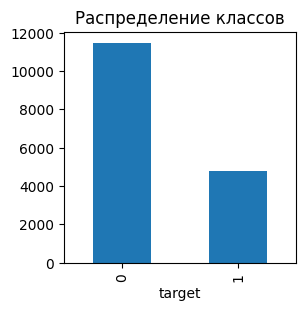

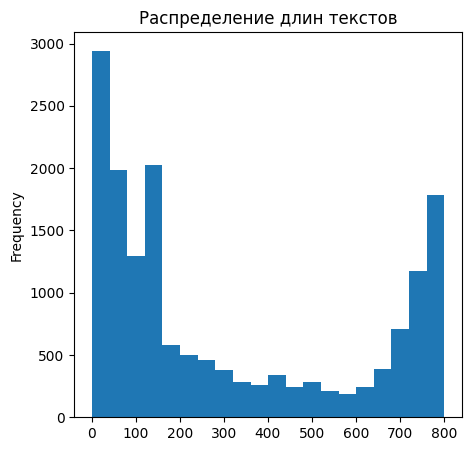

In [4]:
train["target"].value_counts().plot(kind="bar", figsize=(3,3), title='Распределение классов')
plt.show()
train['text'].apply(len).plot(kind="hist", figsize=(5,5), bins=20, title='Распределение длин текстов')
plt.show()

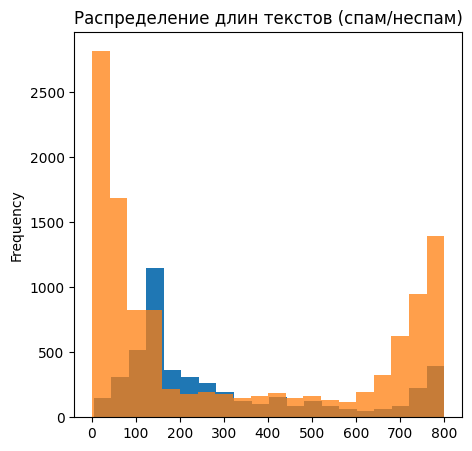

In [5]:
train['text'][train['target']==1].apply(len).plot(kind="hist", figsize=(5,5), bins=20, title='Распределение длин текстов (спам/неспам)')
train['text'][train['target']==0].apply(len).plot(kind="hist", figsize=(5,5), bins=20, title='Распределение длин текстов (спам/неспам)', alpha=0.75)
plt.show()

Частота слов

In [23]:
stop_words = set(stopwords.words('english'))
train['text'] = train['text'].apply(lambda x: " ".join(x.lower() for x in x.split() if x not in stop_words))
test['text'] = test['text'].apply(lambda x: " ".join(x.lower() for x in x.split() if x not in stop_words))


word_counts = train['text'].str.split(expand=True).stack().value_counts()
spam_word_counts = train['text'][train['target']==1].str.split(expand=True).stack().value_counts()
not_spam_word_counts = train['text'][train['target']==0].str.split(expand=True).stack().value_counts()

In [7]:
not_spam_word_counts[:20]

1635465     11000
ect          5343
enron        4848
vince        4525
url          3617
hou          2660
kaminski     2365
2000         2204
subject      2110
j            1928
cc           1909
please       1888
com          1852
would        1849
pm           1820
u            1424
like         1423
thanks       1406
time         1370
2001         1347
Name: count, dtype: int64

In [8]:
spam_word_counts[:20]

1635465     1568
free        1051
get          857
1            641
click        554
new          550
2            520
call         515
link         484
one          483
com          479
money        469
please       463
5            450
business     425
best         425
time         416
account      413
want         411
company      405
Name: count, dtype: int64

### Models

In [19]:
def report_information(y_prediction, y_real=y_test):
    print(classification_report(y_real, y_prediction))
    auc = metrics.roc_auc_score(y_real, y_prediction)
    print("ROC AUC: {:.3f}".format(auc))

    fpr, tpr, thresholds = metrics.roc_curve(y_real, y_prediction)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()

In [9]:
rnd_state = 17
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.2, random_state=rnd_state)

Так как у нас не очень большой датасет и размер текстов. Можем изначально попробовать стандратные методы машинного обучения

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2602
           1       0.63      0.92      0.75       654

    accuracy                           0.88      3256
   macro avg       0.80      0.89      0.83      3256
weighted avg       0.91      0.88      0.88      3256

ROC AUC: 0.892


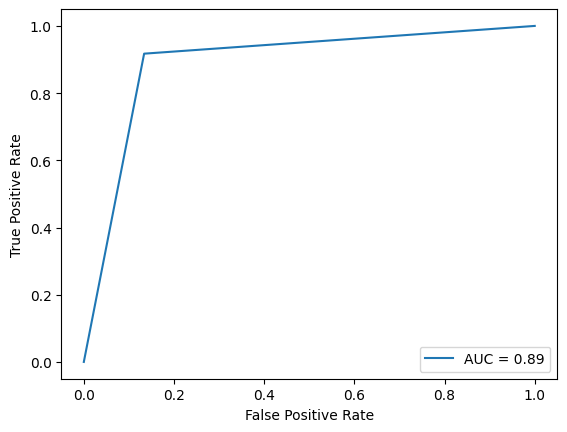

In [32]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

model_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_nb.fit(X_train, y_train)
predictions_nb = model_nb.predict(X_test)
report_information(y_test, predictions_nb)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2559
           1       0.73      0.99      0.84       697

    accuracy                           0.92      3256
   macro avg       0.86      0.95      0.89      3256
weighted avg       0.94      0.92      0.92      3256

ROC AUC: 0.945


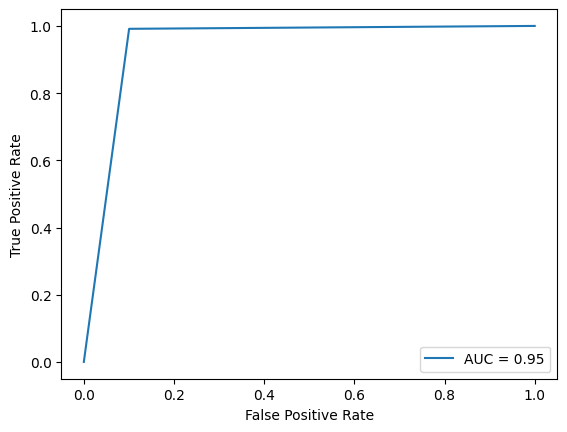

In [144]:
model_nb = make_pipeline(TfidfVectorizer(), BernoulliNB())
model_nb.fit(X_train, y_train)
predictions_nb = model_nb.predict(X_test)
report_information(y_test, predictions_nb)

#### DecisionTrees

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2336
           1       0.81      0.83      0.82       920

    accuracy                           0.90      3256
   macro avg       0.87      0.88      0.87      3256
weighted avg       0.90      0.90      0.90      3256

ROC AUC: 0.877


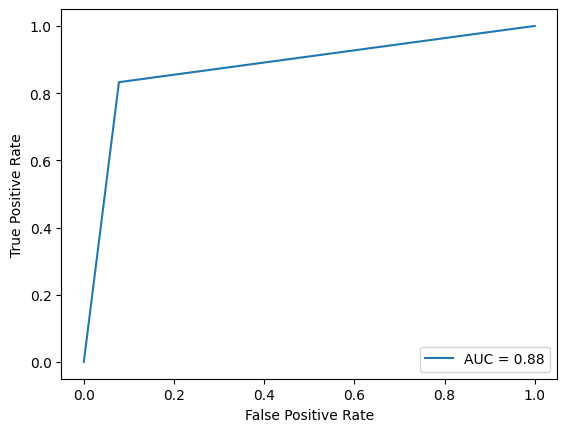

In [128]:
from sklearn.tree import DecisionTreeClassifier

model_dt = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(random_state=rnd_state))
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)
report_information(y_test, predictions_dt)

In [133]:
model_dt[1]

DecisionTreeClassifier(random_state=17)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2484
           1       0.79      0.97      0.87       772

    accuracy                           0.93      3256
   macro avg       0.89      0.95      0.91      3256
weighted avg       0.94      0.93      0.93      3256

ROC AUC: 0.945


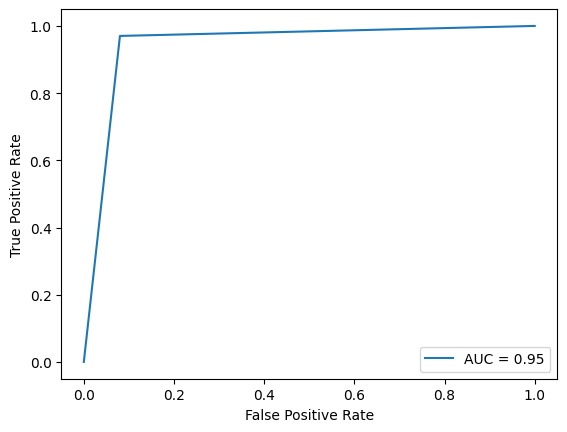

In [126]:
from sklearn.ensemble import RandomForestClassifier

model_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=rnd_state))
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
report_information(y_test, predictions_rf)

Ожидаемо что у ансамбля RandomForest лучше показатели

#### RobertaForSequenceClassification

Используем SOTA модель основанную на трансформере

In [10]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

! pip -q install transformers torch

In [11]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=rnd_state)

In [12]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)
_ = 0

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import torch
class CustomDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length):
        self.text = text.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.text[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {}
        item['input_ids'] = encoding['input_ids'].squeeze()
        item['attention_mask'] = encoding['attention_mask'].squeeze()
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.text)

train_dataset = CustomDataset(X_train_, y_train_, tokenizer, 512)
val_dataset = CustomDataset(X_val, y_val, tokenizer, 512)

In [14]:
train_dataset = CustomDataset(X_train_, y_train_, tokenizer, 512)
val_dataset = CustomDataset(X_val, y_val, tokenizer, 512)

batch_size = 10
num_epochs = 4


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

train_losses = list()
val_losses = list()
val_accuracies = list()
val_precisions = list()
val_recalls = list()
val_f1_scores = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'Training Loss': train_loss / (batch_size * (progress_bar.n + 1))})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    total_val_loss = 0.0
    val_accuracy = 0.0
    val_precision = 0.0
    val_recall = 0.0

    with torch.no_grad():
        y_true = []
        y_pred = []

        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            logits = outputs.logits
            total_val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)

            y_true.extend(labels.tolist())
            y_pred.extend(predictions.tolist())

        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)
        rep = classification_report(y_true, y_pred, output_dict=True)
        val_accuracy, val_precision, val_recall, val_f1 =rep['accuracy'], rep['1']['precision'], rep['1']['recall'], rep['1']['f1-score']
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f} - Val Precision: {val_precision:.4f} - Val Recall: {val_recall:.4f}')


Epoch 1/5 - Train Loss: 0.2368 - Val Loss: 0.1540 - Val Accuracy: 0.9632 - Val Precision: 0.9688 - Val Recall: 0.9021


KeyboardInterrupt: 

In [16]:
print('Epoch 1/5 - Train Loss: 0.2368 - Val Loss: 0.1540 - Val Accuracy: 0.9632 - Val Precision: 0.9688 - Val Recall: 0.9021')
print('Epoch 2/5 - Train Loss: 93.8529 - Val Loss: 0.2902 - Val Accuracy: 0.9701 - Val Precision: 0.9644 - Val Recall: 0.9312')

Epoch 2/5 - Train Loss: 93.8529 - Val Loss: 0.2902 - Val Accuracy: 0.9701 - Val Precision: 0.9644 - Val Recall: 0.9312


In [17]:
test_dataset = CustomDataset(X_test, y_test, tokenizer, 512)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

with torch.no_grad():
      y_true = []
      y_pred = []

      for batch in test_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

          loss = outputs.loss
          logits = outputs.logits
          total_val_loss += loss.item()

          predictions = torch.argmax(logits, dim=1)

          y_true.extend(labels.tolist())
          y_pred.extend(predictions.tolist())

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2368
           1       0.91      0.97      0.94       888

    accuracy                           0.97      3256
   macro avg       0.95      0.97      0.96      3256
weighted avg       0.97      0.97      0.97      3256

ROC AUC: 0.968


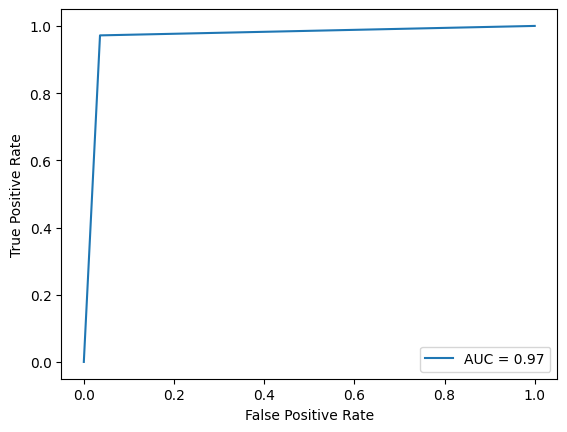

In [20]:
report_information(y_true, y_pred)

Как и предпалогалось, модель основанная на трансформерах показала лучший результат. Теперь обучим модель с 0 на трейновых данных и и проскорим данные нам тестовые  данные

### Scoring

In [26]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)
_

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0

In [27]:
origin_train_dataset = CustomDataset(train['text'], train['target'], tokenizer, 512)
origin_train_loader = DataLoader(origin_train_dataset, batch_size=batch_size, shuffle=True)

batch_size = 10
num_epochs = 3

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(origin_train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

train_losses = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    progress_bar = tqdm(origin_train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'Training Loss': train_loss / (batch_size * (progress_bar.n + 1))})

    train_loss /= len(origin_train_loader)
    train_losses.append(train_loss)

KeyboardInterrupt: 

In [31]:
train['target'] * 0

0        0
1        0
2        0
3        0
4        0
        ..
16273    0
16274    0
16275    0
16276    0
16277    0
Name: target, Length: 16278, dtype: int64

In [43]:
import torch.nn.functional as F

origin_test_dataset = CustomDataset(test['text'], train['target'][:test.shape[0]] * 0, tokenizer, 512)
origin_test_loader = DataLoader(origin_test_dataset, batch_size=batch_size, shuffle=False)

model.eval()

with torch.no_grad():
    y_pred = []
    y_logits = []
    y_probs_0 = []
    y_probs_1 = []

    for batch in origin_test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)


        y_logits.append(logits)
        y_pred.extend(predictions.tolist())
        y_probs_0.extend(probabilities[:, 0].tolist())
        y_probs_1.extend(probabilities[:, 1].tolist())

In [50]:
test['probs_0'] = y_probs_0
test['probs_1'] = y_probs_1
test['prrediction'] = y_pred

In [54]:
test.to_csv('test_spam_all.csv')
test[['prrediction','probs_1','probs_0']].to_csv('test_spam_predictions.csv')